## Install deps

In [1]:
!pip install pandas numpy requests matplotlib
!pip install tf-agents
!pip install tf-keras

  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 8.25.0 requires typing-extensions>=4.6; python_version < "3.12", but you have typing-extensions 4.5.0 which is incompatible.


In [2]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

### Download the dataset from my netlify deployment. As Collab is ephemeral
And I am lazy to spin up new nginx on my traefik host at home

In [3]:
import requests
base_url = "https://dc-bandits-ab-06e963.netlify.app/dataset-"
files = ["zakladni.csv","discovery.csv","segment.csv"]

for file in files:
  response = requests.get(base_url+file, stream=True)
  with open(file,'wb') as output:
    output.write(response.content)

## Data preparation
Aggregate the data by 30 minutes intervals

In [13]:
import pandas as pd
import numpy as np

data = pd.DataFrame()
for file in files:
  variant = pd.read_csv(file)
  variant['minute'] = pd.to_datetime(variant['minute'])
  variant.set_index('minute', inplace=True)
  variant = variant.resample('6h').agg({'visits':'sum', 'clicks':'sum'}).dropna()

  variant.index.rename("interval", inplace=True)
  variant['variant'] = file.replace(".csv", "")
  
  # Precompute CTR
  variant['CTR'] = variant['clicks'] / variant['visits']
  
  data = pd.concat([data, variant])
print(data.head())
print(data.tail())

                     visits  clicks   variant       CTR
interval                                               
2023-03-06 12:00:00    1068      16  zakladni  0.014981
2023-03-07 00:00:00    1024      25  zakladni  0.024414
2023-03-07 12:00:00    1949      39  zakladni  0.020010
2023-03-08 00:00:00    1025      23  zakladni  0.022439
2023-03-08 12:00:00    2008      47  zakladni  0.023406
                     visits  clicks  variant       CTR
interval                                              
2023-03-22 12:00:00    2072      38  segment  0.018340
2023-03-23 00:00:00    1152      18  segment  0.015625
2023-03-23 12:00:00    1827      30  segment  0.016420
2023-03-24 00:00:00    1060      27  segment  0.025472
2023-03-24 12:00:00     245      14  segment  0.057143


## Prepare Tensorflow Bandit Agents

In [16]:
import tensorflow as tf

from tf_agents.bandits.environments.bandit_py_environment import BanditPyEnvironment
from tf_agents.specs import array_spec


class ABCTestBanditEnv(BanditPyEnvironment):
    def __init__(self, data):
        self.data = data
        self.current = 0

        # Num of A/B variants (actions)
        self.variants = data['variant'].unique()
        action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=len(self.variants) - 1, name='action')

        # Define observation as a vector of the day of the week (0-6) and hour of the day (0-23)
        observation_spec = array_spec.ArraySpec(
            shape=(2,), dtype=np.int32, name='observation')

        super(ABCTestBanditEnv, self).__init__(observation_spec, action_spec)

        # Normalize day and hour for observations
        self.data['day_of_week'] = self.data.index.dayofweek
        self.data['hour_of_day'] = self.data.index.hour

    def _observe(self):
        if self.current >= len(self.data):
            self.current = 0 
        # Construct the observation from the current interval
        obs_data = self.data.iloc[self.current]
        self._observation = np.array([obs_data['day_of_week'], obs_data['hour_of_day']], dtype='int32')
        return self._observation

    def _apply_action(self, action):
        # Get the current time interval data
        obs_data = self.data.iloc[self.current]
        current_time = obs_data.name

        current_interval_data = self.data.loc[current_time]
        total_visits = current_interval_data['visits'].sum()

        # Allocate traffic based on action taken
        chosen_variant = self.variants[action]
        chosen_variant_data = current_interval_data[current_interval_data['variant'] == chosen_variant]

        # Calculate the new visits and clicks based on the chosen variant's CTR
        new_clicks = total_visits * chosen_variant_data['CTR'].values[0]

        # Calculate reward as the CTR
        reward = new_clicks / total_visits if total_visits > 0 else 0
        print(reward)
        self.current += 1
        return reward




In [24]:
from tf_agents.environments import tf_py_environment
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory

# Create the environment
env = ABCTestBanditEnv(data)
env = tf_py_environment.TFPyEnvironment(env)

# Define time_step_spec and action_spec
time_step_spec = env.time_step_spec()
action_spec = env.action_spec()

# Initialize the agent
agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec=time_step_spec,
    action_spec=action_spec,
    alpha=0.5,  # Adjust exploration level
    tikhonov_weight=1.0,  # Regularization to prevent overfitting
    dtype=tf.float32
)

# Setup Replay Buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=env.batch_size,
    max_length=1000)

actions_taken = []

# Function to collect data from interactions
def collect_step(env, policy):
    time_step = env.current_time_step()
    action_step = policy.action(time_step)
    # Log
    actions_taken.append(action_step.action.numpy())
    next_time_step = env.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

# Training Loop
num_iterations = len(data) / data['variant'].unique() # Number of iterations for training
for _ in range(num_iterations):
    # Collect data from the environment
    collect_step(env, agent.policy)

    # Sample a batch of data from the buffer and update the agent's network
    experience = replay_buffer.gather_all()
    train_loss = agent.train(experience)
    replay_buffer.clear()

    print(f"Step: {_}, Loss: {train_loss.loss.numpy()}")

print("Training completed.")

visits             1068
clicks               16
variant        zakladni
CTR            0.014981
day_of_week           0
hour_of_day          12
Name: 2023-03-06 12:00:00, dtype: object
0.0149812734082397
Step: 0, Loss: 0.00022443855414167047
visits             1024
clicks               25
variant        zakladni
CTR            0.024414
day_of_week           1
hour_of_day           0
Name: 2023-03-07 00:00:00, dtype: object
0.0244140625
Step: 1, Loss: 0.0005960464477539062
visits             1949
clicks               39
variant        zakladni
CTR             0.02001
day_of_week           1
hour_of_day          12
Name: 2023-03-07 12:00:00, dtype: object
0.02029136316337149
Step: 2, Loss: 0.00041173945646733046
visits             1025
clicks               23
variant        zakladni
CTR            0.022439
day_of_week           2
hour_of_day           0
Name: 2023-03-08 00:00:00, dtype: object
0.02186311787072243
Step: 3, Loss: 0.00047799592721275985
visits             2008
clicks       

      zakladni  discovery  segment
step                              
999       37.7       26.1     36.2


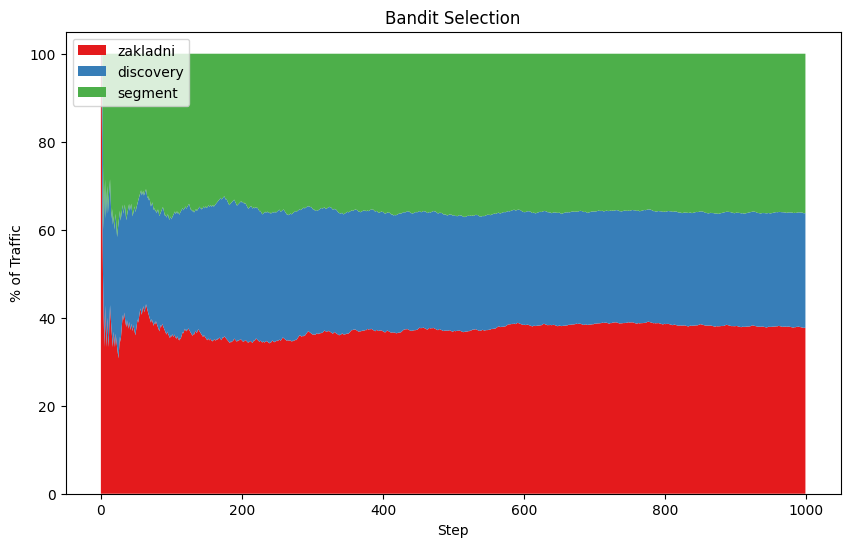

In [23]:
import matplotlib.pyplot as plt

actions_df = pd.DataFrame(actions_taken, columns=['action'])
actions_df['step'] = actions_df.index

# Count the occurrences of each action at each step
actions_count_df = actions_df.groupby(['step', 'action']).size().unstack(fill_value=0)

# Calculate the cumulative sum to get the traffic over time
cumulative_counts = actions_count_df.cumsum()

# Calculate the percentage of traffic allocated to each variant
cumulative_percents = cumulative_counts.div(cumulative_counts.sum(axis=1), axis=0) * 100

cumulative_percents.columns = data['variant'].unique()
print(cumulative_percents.tail(1), )
# Plotting the area chart
plt.figure(figsize=(10, 6))
plt.stackplot(cumulative_percents.index, cumulative_percents.T, labels=cumulative_percents.columns, colors=['#e41a1c', '#377eb8', '#4daf4a'])
plt.legend(loc='upper left')
plt.xlabel('Step')
plt.ylabel('% of Traffic')
plt.title('Bandit Selection')
plt.show()

In [ ]:
def simulate_clicks(row):
    visits = int(row['visits'])
    clicks = int(row['clicks'])
    if visits == 0:
        probability
    else:
        probability = clicks / visits
    # Bernoulliho schéma
    clicks = np.random.binomial(1, probability, visits)
    return clicks

Add rewards simulation